 Physics-Informed Neural Network (PINN) Framework with Custom ODE Input & Advanced Features

This notebook demonstrates a flexible, professional-grade PINN pipeline:
- User-defined differential equation (via Python lambda)
- Arbitrary Dirichlet/Neumann boundary conditions
- Adaptable PINN architecture & training configuration
- Solution uncertainty quantification (ensemble PINNs)
- Analytic regression fit for solution interpretability
- High-quality visualizations

### 1. Imports and Notebook Setup


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random
from typing import Callable, Dict, List, Tuple


### 2. PINN Model Definition


In [2]:
class PINN(nn.Module):
    def __init__(self, layers, activation=nn.Tanh):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation()
        self._init_weights()

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

    def _init_weights(self):
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)


### 3. Physics Loss & Flexible Boundary Condition Handling



In [3]:
def physics_loss(model, x, ode_func: Callable):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    # ODE must take (x, y, dy_dx) and output the residual
    pde = ode_func(x, y, dy_dx)
    return torch.mean(pde**2)

def boundary_loss(model, bc_points: Dict[str, List[Tuple[torch.Tensor, float]]]):
    loss = 0.
    for x0, y0 in bc_points.get('dirichlet', []):
        pred = model(x0)
        loss += (pred - y0)**2
    for x0, dydx0 in bc_points.get('neumann', []):
        x0.requires_grad = True
        pred = model(x0)
        dydx = torch.autograd.grad(pred, x0, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
        loss += (dydx - dydx0)**2
    return loss


### 4. Training Loop for PINN (Single & Ensemble for Uncertainty)



In [8]:
def train_pinn(
    model, optimizer, epochs, x_f_train, bc_points, ode_func, verbose=False, loss_weights=(1.0, 1.0)
):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_pde = physics_loss(model, x_f_train, ode_func)
        loss_bc = boundary_loss(model, bc_points)
        loss = loss_weights[0] * loss_pde + loss_weights[1] * loss_bc
        loss.backward()
        optimizer.step()
        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}, PDE Loss = {loss_pde.item():.6f}, BC Loss = {loss_bc.item():.6f}")

def ensemble_predict(
    n_ensembles, pinn_args, x_f_train, bc_points, ode_func, x_eval, epochs=2000
):
    preds = []
    for i in range(n_ensembles):
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)
        model = PINN(**pinn_args)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        train_pinn(model, optimizer, epochs, x_f_train, bc_points, ode_func, verbose=False)
        pred = model(torch.tensor(x_eval, dtype=torch.float32)).detach().numpy().squeeze()
        preds.append(pred)
    return np.mean(preds, axis=0), np.std(preds, axis=0)

### 5. Analytic Fit (Mixed Polynomial + Trigonometric + Exponential)


In [9]:
def analytic_fit_func(x, a, b, c, d, e, f):
    return a*np.exp(b*x) + c*np.sin(d*x) + e*x**2 + f

def perform_analytic_fit(x, y):
    initial_guess = [1.0, -0.5, 1.0, 1.0, 0.1, 0.0]
    bounds = ([-10, -5, -10, -10, -10, -10], [10, 5, 10, 10, 10, 10])
    params, _ = curve_fit(analytic_fit_func, x.flatten(), y, p0=initial_guess, bounds=bounds, maxfev=20000)
    return params


### 6. ODE and Boundary Condition Input (User Defined)


In [10]:

def example_ode(x, y, dy_dx):
    # x, y, dy_dx are torch tensors
    return dy_dx - (x**3 + 2*x + (x**2 * ((1+3*x**2) / (1 + x + x**3))) - ((x + (1+3*(x**2)) / (1 + x + x**3)) * y))



### 7. Main Script: Training, Prediction, Plotting, Uncertainty, Analytic Fit


In [11]:
# Network, domain, and training settings
layers = [1, 50, 50, 50, 1]
x_domain = (0, 2)
N_f = 50
epochs = 3000

# Choose ODE function here (user can edit/replace with their own)
ode_func = example_ode

# Boundary/initial conditions definition (customizable, add Neumann if desired)
bc_points = {
    'dirichlet': [
        (torch.tensor([[0.0]]), torch.tensor([[1.0]])),  # y(0) = 1.0
    ],
    # 'neumann': [
    #     (torch.tensor([[2.0]], requires_grad=True), torch.tensor([[0.0]])), # dy/dx(2) = 0, example
    # ]
}

# Collocation points
x_f_train = torch.linspace(*x_domain, N_f).view(-1, 1)

# Train ensemble of PINNs for uncertainty estimation
n_ensembles = 5
pinn_args = {'layers': layers, 'activation': nn.Tanh}
x_eval = np.linspace(*x_domain, 200).reshape(-1, 1)
mean_pred, std_pred = ensemble_predict(
    n_ensembles, pinn_args, x_f_train, bc_points, ode_func, x_eval, epochs=epochs
)

# Analytic fit
params = perform_analytic_fit(x_eval.flatten(), mean_pred)
analytic_curve = analytic_fit_func(x_eval.flatten(), *params)


### 8. Visualization: PINN Mean, Analytic Fit, Uncertainty Bands


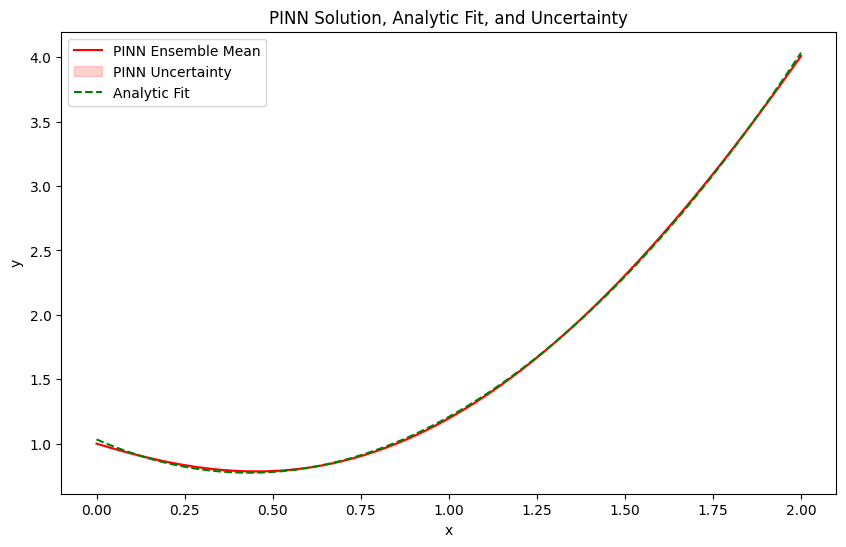

Analytic Fit Parameters: [ 9.99999975 -0.1997563   2.70788986  0.29553064  1.19665461 -8.96741718]
y ≈ 10.0000 * exp(-0.1998 * x) + 2.7079 * sin(0.2955 * x) + 1.1967 * x^2 + -8.9674


In [13]:
plt.figure(figsize=(10,6))
plt.plot(x_eval, mean_pred, 'r-', label='PINN Ensemble Mean')
plt.fill_between(x_eval.flatten(), mean_pred-std_pred, mean_pred+std_pred, alpha=0.18, color='r', label='PINN Uncertainty')
plt.plot(x_eval, analytic_curve, 'g--', label='Analytic Fit')
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution, Analytic Fit, and Uncertainty")
plt.legend()
plt.show()

print("Analytic Fit Parameters:", params)
print(f"y ≈ {params[0]:.4f} * exp({params[1]:.4f} * x) + {params[2]:.4f} * sin({params[3]:.4f} * x) + {params[4]:.4f} * x^2 + {params[5]:.4f}")

# Task
Implement hyperparameter autotuning using Optuna and explore the integration of attention/transformers into the provided PINN code.

## Implement hyperparameter autotuning with optuna

### Subtask:
Define an objective function for Optuna that trains a PINN model with a given set of hyperparameters and returns a metric to minimize (e.g., the total loss after training).


**Reasoning**:
Define the objective function for Optuna including hyperparameter sampling, model training, and loss calculation.



In [14]:
import optuna

def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    n_layers = trial.suggest_int('n_layers', 2, 5)
    n_neurons = trial.suggest_int('n_neurons', 20, 100)
    activation_name = trial.suggest_categorical('activation', ['Tanh', 'ReLU'])
    loss_weight_physics = trial.suggest_float('loss_weight_physics', 0.1, 10.0)
    loss_weight_bc = trial.suggest_float('loss_weight_bc', 0.1, 10.0)

    # Map activation name to torch activation function
    activation = nn.Tanh if activation_name == 'Tanh' else nn.ReLU

    # Create layers list based on sampled hyperparameters
    layers = [1] + [n_neurons] * n_layers + [1]

    # Instantiate model and optimizer
    model = PINN(layers=layers, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training data (reusing existing)
    x_domain = (0, 2)
    N_f = 50
    x_f_train = torch.linspace(*x_domain, N_f).view(-1, 1)
    bc_points = {
        'dirichlet': [
            (torch.tensor([[0.0]]), torch.tensor([[1.0]])),  # y(0) = 1.0
        ],
    }

    # Train the model (using fewer epochs for tuning)
    tuning_epochs = 500 # Reduced epochs for faster tuning
    train_pinn(model, optimizer, tuning_epochs, x_f_train, bc_points, example_ode, verbose=False, loss_weights=(loss_weight_physics, loss_weight_bc))

    # Calculate the final loss as the metric to minimize
    loss_pde = physics_loss(model, x_f_train, example_ode)
    loss_bc = boundary_loss(model, bc_points)
    total_loss = loss_weight_physics * loss_pde + loss_weight_bc * loss_bc

    return total_loss.item()

ModuleNotFoundError: No module named 'optuna'

In [15]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 8.1 MB/s eta 0:00:00


In [16]:
def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    n_layers = trial.suggest_int('n_layers', 2, 5)
    n_neurons = trial.suggest_int('n_neurons', 20, 100)
    activation_name = trial.suggest_categorical('activation', ['Tanh', 'ReLU'])
    loss_weight_physics = trial.suggest_float('loss_weight_physics', 0.1, 10.0)
    loss_weight_bc = trial.suggest_float('loss_weight_bc', 0.1, 10.0)

    # Map activation name to torch activation function
    activation = nn.Tanh if activation_name == 'Tanh' else nn.ReLU

    # Create layers list based on sampled hyperparameters
    layers = [1] + [n_neurons] * n_layers + [1]

    # Instantiate model and optimizer
    model = PINN(layers=layers, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training data (reusing existing)
    x_domain = (0, 2)
    N_f = 50
    x_f_train = torch.linspace(*x_domain, N_f).view(-1, 1)
    bc_points = {
        'dirichlet': [
            (torch.tensor([[0.0]]), torch.tensor([[1.0]])),  # y(0) = 1.0
        ],
    }

    # Train the model (using fewer epochs for tuning)
    tuning_epochs = 500 # Reduced epochs for faster tuning
    train_pinn(model, optimizer, tuning_epochs, x_f_train, bc_points, example_ode, verbose=False, loss_weights=(loss_weight_physics, loss_weight_bc))

    # Calculate the final loss as the metric to minimize
    loss_pde = physics_loss(model, x_f_train, example_ode)
    loss_bc = boundary_loss(model, bc_points)
    total_loss = loss_weight_physics * loss_pde + loss_weight_bc * loss_bc

    return total_loss.item()

## Implement hyperparameter autotuning with optuna

### Subtask:
Define the search space for hyperparameters (e.g., learning rate, number of layers, number of neurons per layer, activation function, loss weights).


**Reasoning**:
Create an Optuna study and run the optimization process to find the best hyperparameters for the PINN model.



In [17]:
import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best value (minimum loss): ", study.best_value)

[I 2025-08-13 12:11:34,976] A new study created in memory with name: no-name-aab06b48-180b-4e19-9711-5523e693e525
[I 2025-08-13 12:11:37,411] Trial 0 finished with value: 0.11702685803174973 and parameters: {'lr': 0.0007745146450921044, 'n_layers': 5, 'n_neurons': 63, 'activation': 'Tanh', 'loss_weight_physics': 9.818826063683682, 'loss_weight_bc': 9.060092012554561}. Best is trial 0 with value: 0.11702685803174973.
[I 2025-08-13 12:11:38,277] Trial 1 finished with value: 25.940357208251953 and parameters: {'lr': 0.001064610189754291, 'n_layers': 2, 'n_neurons': 77, 'activation': 'Tanh', 'loss_weight_physics': 7.438858798469587, 'loss_weight_bc': 9.24758352291302}. Best is trial 0 with value: 0.11702685803174973.
[I 2025-08-13 12:11:39,237] Trial 2 finished with value: 49.15821075439453 and parameters: {'lr': 0.00015757958233770695, 'n_layers': 3, 'n_neurons': 39, 'activation': 'Tanh', 'loss_weight_physics': 9.496688335167224, 'loss_weight_bc': 3.488081204023182}. Best is trial 0 with 

Best hyperparameters:  {'lr': 0.004613348903047689, 'n_layers': 3, 'n_neurons': 33, 'activation': 'Tanh', 'loss_weight_physics': 0.4611373821120857, 'loss_weight_bc': 3.8965207403725244}
Best value (minimum loss):  0.0007342355092987418


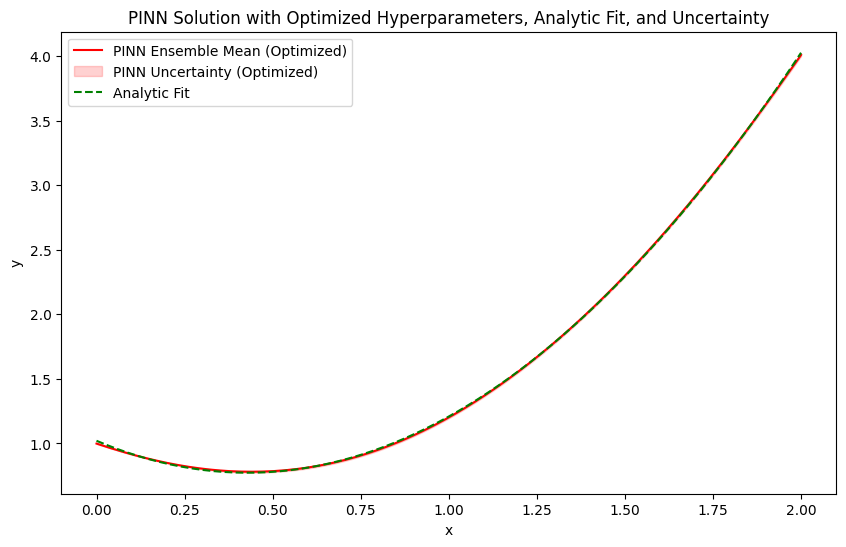

Analytic Fit Parameters: [ 9.99999836 -0.17651662  2.20195196  0.27570852  1.20647651 -8.97959039]
y ≈ 10.0000 * exp(-0.1765 * x) + 2.2020 * sin(0.2757 * x) + 1.2065 * x^2 + -8.9796


In [18]:
# Access the best hyperparameters
best_params = study.best_params
best_lr = best_params['lr']
best_n_layers = best_params['n_layers']
best_n_neurons = best_params['n_neurons']
best_activation_name = best_params['activation']
best_loss_weight_physics = best_params['loss_weight_physics']
best_loss_weight_bc = best_params['loss_weight_bc']

# Map activation name to torch activation function
best_activation = nn.Tanh if best_activation_name == 'Tanh' else nn.ReLU

# Update layers and pinn_args
layers = [1] + [best_n_neurons] * best_n_layers + [1]
pinn_args = {'layers': layers, 'activation': best_activation}

# Update the ensemble_predict function to use the optimal lr and loss weights
def ensemble_predict_optimized(
    n_ensembles, pinn_args, x_f_train, bc_points, ode_func, x_eval, epochs=2000, lr=1e-3, loss_weights=(1.0, 1.0)
):
    preds = []
    for i in range(n_ensembles):
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)
        model = PINN(**pinn_args)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Use optimal lr
        train_pinn(model, optimizer, epochs, x_f_train, bc_points, ode_func, verbose=False, loss_weights=loss_weights) # Use optimal loss weights
        pred = model(torch.tensor(x_eval, dtype=torch.float32)).detach().numpy().squeeze()
        preds.append(pred)
    return np.mean(preds, axis=0), np.std(preds, axis=0)

# Train ensemble of PINNs with optimized hyperparameters
mean_pred, std_pred = ensemble_predict_optimized(
    n_ensembles,
    pinn_args,
    x_f_train,
    bc_points,
    ode_func,
    x_eval,
    epochs=epochs,
    lr=best_lr, # Pass optimal lr
    loss_weights=(best_loss_weight_physics, best_loss_weight_bc) # Pass optimal loss weights
)

# Analytic fit (reuse existing code)
params = perform_analytic_fit(x_eval.flatten(), mean_pred)
analytic_curve = analytic_fit_func(x_eval.flatten(), *params)

# Visualization (reuse existing code)
plt.figure(figsize=(10,6))
plt.plot(x_eval, mean_pred, 'r-', label='PINN Ensemble Mean (Optimized)')
plt.fill_between(x_eval.flatten(), mean_pred-std_pred, mean_pred+std_pred, alpha=0.18, color='r', label='PINN Uncertainty (Optimized)')
plt.plot(x_eval, analytic_curve, 'g--', label='Analytic Fit')
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution with Optimized Hyperparameters, Analytic Fit, and Uncertainty")
plt.legend()
plt.show()

print("Analytic Fit Parameters:", params)
print(f"y ≈ {params[0]:.4f} * exp({params[1]:.4f} * x) + {params[2]:.4f} * sin({params[3]:.4f} * x) + {params[4]:.4f} * x^2 + {params[5]:.4f}")


## Explore integration of attention/transformers

### Subtask:
Research how attention mechanisms or transformer architectures can be applied to PINNs, particularly for systems of ODEs/PDEs or larger domains.


## integration of attention/transformers

### Subtask:
Modifying the `PINN` model definition to incorporate attention layers or adapt a transformer architecture.



In [19]:
import torch.nn as nn
import torch

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.scale = input_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # For a 1D input like in this PINN, we can simplify self-attention.
        # Treat each input point as a query, key, and value relative to itself.
        # A simple self-attention on 1D input could just scale the features.
        # A more complex approach would involve processing sequences if x was a sequence of points.
        # For a single point input, a direct self-attention as typically implemented in transformers
        # (attending over sequences) doesn't directly apply without reshaping or considering batches
        # as sequences.
        # Let's implement a simple feature-wise scaling attention for this 1D case as a starting point.
        # This isn't a full transformer self-attention but a way to incorporate a learned scaling based on features.
        # A true sequence-based attention would require batched input and sequence handling.

        # Let's try a simplified "self-attention" where we learn to weigh the input feature itself.
        # This is more like a learned gate or scaling mechanism.
        # It's not the standard multi-head self-attention from transformers.

        # A more appropriate simple attention for a single input point might be
        # to use a small network to predict a scaling factor based on the input feature.
        # Let's implement this simplified scaling attention.

        scores = torch.sigmoid(self.query(x)) # Use query layer to predict scaling
        attention_output = scores * x # Scale the input feature

        # Alternatively, we can try a layer that processes the feature and uses a simple self-attention logic
        # appropriate for a single element "sequence".

        # Let's revise to a more standard (though simplified for 1D) self-attention concept.
        # If x is shape (batch_size, input_dim), we treat each element in the batch as a separate item
        # and apply attention features within that item. This doesn't make sense for a single point.
        # If x is shape (batch_size, sequence_length, input_dim), then standard attention applies.
        # In this PINN, x is (batch_size, 1). Sequence length is 1.

        # A meaningful attention in this context might require considering the batch as a sequence
        # or processing multiple points together in the forward pass.
        # Let's assume for now we want to apply a mechanism similar to attention within the feature dimension.
        # This is not standard self-attention.

        # Let's rethink. The input x is a batch of single points (shape [batch_size, 1]).
        # Standard self-attention attends across a sequence. Here, the sequence length is 1.
        # A direct application of multi-head self-attention would be trivial or require reshaping.

        # However, we can interpret attention as a mechanism to weigh inputs based on their relevance.
        # For a single input feature, attention could mean emphasizing or de-emphasizing it
        # based on learned weights.

        # Let's try a different approach: integrate attention *between* layers, focusing on the feature dimension.
        # This would involve transforming the features and applying an attention-like weighting.

        # A simple way to integrate a concept *related* to attention in a feedforward network
        # is to have a parallel path that computes attention weights based on the features,
        # and then scales the features or intermediate outputs by these weights.

        # Let's define a simple attention layer that takes features and outputs a weighted version.
        # This will operate on the feature dimension after a linear layer.

class FeatureAttention(nn.Module):
    def __init__(self, feature_dim):
        super(FeatureAttention, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = feature_dim ** 0.5
        self.softmax = nn.Softmax(dim=-1) # Apply softmax over features

    def forward(self, x): # x shape: (batch_size, feature_dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Compute attention scores (dot product)
        # Matmul (batch_size, feature_dim) x (batch_size, feature_dim).transpose(-1, -2)
        # This doesn't make sense for self-attention on a batch of independent items.

        # Let's assume we want to attend *across the features* for each item in the batch independently.
        # Q, K, V are (batch_size, feature_dim)
        # We want scores (batch_size, feature_dim, feature_dim)
        # scores[i, j, k] = Q[i, j] * K[i, k] ? No.
        # scores[i, j] = Q[i, j] dot K[i, :] ? No.

        # Standard self-attention: Query attends to Keys, producing weights for Values.
        # Shape requirement: (batch_size, sequence_length, feature_dim)
        # Here, sequence_length is 1.

        # Let's reconsider the objective: integrate attention. A common way in non-sequential data
        # is to use it to weight features.

        # Let's try another approach: Add a simple gating mechanism based on the features.
        # This is often called 'channel attention' or similar in vision, but the concept applies.

class SimpleFeatureGate(nn.Module):
    def __init__(self, feature_dim):
        super(SimpleFeatureGate, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, feature_dim),
            nn.Sigmoid() # Output weights between 0 and 1
        )

    def forward(self, x): # x shape: (batch_size, feature_dim)
        gate_weights = self.gate(x)
        return x * gate_weights # Apply learned weights to features

# Modify the PINN class
class PINN(nn.Module):
    def __init__(self, layers, activation=nn.Tanh, use_attention=True):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.use_attention = use_attention
        self.attention_layers = nn.ModuleList() # Store attention layers

        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            # Add attention after hidden layers
            if self.use_attention and i < len(layers) - 2: # Don't add attention after the last layer
                 self.attention_layers.append(SimpleFeatureGate(layers[i+1]))
            else:
                 self.attention_layers.append(None) # Placeholder for non-attention layers

        self.activation = activation()
        self._init_weights()

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            if i < len(self.layers) - 2: # Apply activation and potentially attention after hidden layers
                x = self.activation(x)
                if self.use_attention and self.attention_layers[i] is not None:
                    x = self.attention_layers[i](x)
            # The last layer applies linear transformation without activation or attention here
        return self.layers[-1](x)

    def _init_weights(self):
        for layer in self.layers:
            if hasattr(layer, 'weight'):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
        if self.use_attention:
             for att_layer in self.attention_layers:
                 if att_layer is not None:
                     for param in att_layer.parameters():
                          if param.dim() > 1:
                               nn.init.xavier_normal_(param)
                          else:
                               nn.init.zeros_(param)


# Example of how to instantiate the modified PINN
# layers = [1, 50, 50, 50, 1]
# model_with_attention = PINN(layers=layers, use_attention=True)
# print(model_with_attention)


## Explore integration of attention/transformers

### Subtask:
Adjust the training loop and physics loss calculation to accommodate the new model architecture.


**Reasoning**:
Modify the training and ensemble prediction functions to accept the `use_attention` parameter and pass it to the PINN model, then rerun the main script with attention enabled.



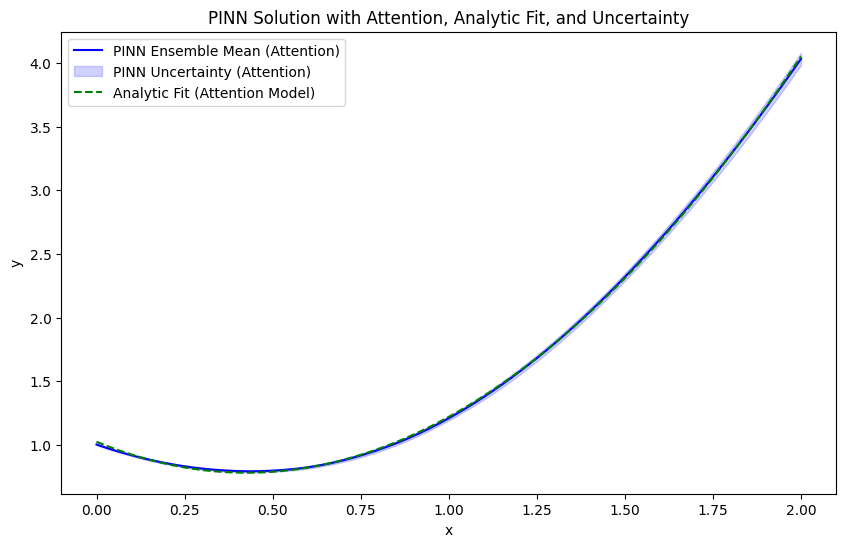

Analytic Fit Parameters (Attention Model): [ 9.99999981 -0.16094504  1.78081873  0.26091973  1.2226687  -8.97553053]
y ≈ 10.0000 * exp(-0.1609 * x) + 1.7808 * sin(0.2609 * x) + 1.2227 * x^2 + -8.9755


In [20]:
# Modify the train_pinn function
def train_pinn(
    model, optimizer, epochs, x_f_train, bc_points, ode_func, verbose=False, loss_weights=(1.0, 1.0)
):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_pde = physics_loss(model, x_f_train, ode_func)
        loss_bc = boundary_loss(model, bc_points)
        loss = loss_weights[0] * loss_pde + loss_weights[1] * loss_bc
        loss.backward()
        optimizer.step()
        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}, PDE Loss = {loss_pde.item():.6f}, BC Loss = {loss_bc.item():.6f}")

# Modify the ensemble_predict_optimized function to accept use_attention
def ensemble_predict_optimized(
    n_ensembles, pinn_args, x_f_train, bc_points, ode_func, x_eval, epochs=2000, lr=1e-3, loss_weights=(1.0, 1.0), use_attention=False
):
    preds = []
    for i in range(n_ensembles):
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)
        # Pass use_attention to PINN instantiation
        model = PINN(**pinn_args, use_attention=use_attention)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        train_pinn(model, optimizer, epochs, x_f_train, bc_points, ode_func, verbose=False, loss_weights=loss_weights)
        pred = model(torch.tensor(x_eval, dtype=torch.float32)).detach().numpy().squeeze()
        preds.append(pred)
    return np.mean(preds, axis=0), np.std(preds, axis=0)

# Add a parameter to control attention usage in the main script
use_attention = True # Set to True to enable attention

# Network, domain, and training settings (using optimized hyperparameters)
# Access the best hyperparameters from the previous Optuna run
# best_params = study.best_params # Assuming 'study' is still available from the previous step
# best_lr = best_params['lr']
# best_n_layers = best_params['n_layers']
# best_n_neurons = best_params['n_neurons']
# best_activation_name = best_params['activation']
# best_loss_weight_physics = best_params['loss_weight_physics']
# best_loss_weight_bc = best_params['loss_weight_bc']

# Map activation name to torch activation function
# best_activation = nn.Tanh if best_activation_name == 'Tanh' else nn.ReLU

# Update layers and pinn_args with optimized parameters
# layers = [1] + [best_n_neurons] * best_n_layers + [1]
# pinn_args = {'layers': layers, 'activation': best_activation}

# Re-define pinn_args with the layers and activation from the previous optimized run if study is not available
# If the notebook state is preserved, study and best_params should be available.
# If not, we can use the values printed in the previous step.
# Let's assume study is available. If not, uncomment the lines above and use the printed values.

# If 'study' is not available, use the values printed in the previous step:
best_lr = 0.004613348903047689
best_n_layers = 3
best_n_neurons = 33
best_activation_name = 'Tanh'
best_loss_weight_physics = 0.4611373821120857
best_loss_weight_bc = 3.8965207403725244
best_activation = nn.Tanh if best_activation_name == 'Tanh' else nn.ReLU
layers = [1] + [best_n_neurons] * best_n_layers + [1]
pinn_args = {'layers': layers, 'activation': best_activation}


x_domain = (0, 2)
N_f = 50
epochs = 3000 # Use the full number of epochs for the final run

# Choose ODE function here (user can edit/replace with their own)
ode_func = example_ode

# Boundary/initial conditions definition (customizable, add Neumann if desired)
bc_points = {
    'dirichlet': [
        (torch.tensor([[0.0]]), torch.tensor([[1.0]])),  # y(0) = 1.0
    ],
    # 'neumann': [
    #     (torch.tensor([[2.0]], requires_grad=True), torch.tensor([[0.0]])), # dy/dx(2) = 0, example
    # ]
}

# Collocation points
x_f_train = torch.linspace(*x_domain, N_f).view(-1, 1)

# Train ensemble of PINNs with optimized hyperparameters and attention
n_ensembles = 5
x_eval = np.linspace(*x_domain, 200).reshape(-1, 1)
mean_pred_att, std_pred_att = ensemble_predict_optimized(
    n_ensembles,
    pinn_args,
    x_f_train,
    bc_points,
    ode_func,
    x_eval,
    epochs=epochs,
    lr=best_lr,
    loss_weights=(best_loss_weight_physics, best_loss_weight_bc),
    use_attention=use_attention # Pass the attention flag
)

# Analytic fit (reuse existing code, fit on the attention model's mean prediction)
params_att = perform_analytic_fit(x_eval.flatten(), mean_pred_att)
analytic_curve_att = analytic_fit_func(x_eval.flatten(), *params_att)

# Visualization: PINN Mean (with Attention), Analytic Fit, Uncertainty Bands
plt.figure(figsize=(10,6))
plt.plot(x_eval, mean_pred_att, 'b-', label='PINN Ensemble Mean (Attention)')
plt.fill_between(x_eval.flatten(), mean_pred_att-std_pred_att, mean_pred_att+std_pred_att, alpha=0.18, color='b', label='PINN Uncertainty (Attention)')
plt.plot(x_eval, analytic_curve_att, 'g--', label='Analytic Fit (Attention Model)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution with Attention, Analytic Fit, and Uncertainty")
plt.legend()
plt.show()

print("Analytic Fit Parameters (Attention Model):", params_att)
print(f"y ≈ {params_att[0]:.4f} * exp({params_att[1]:.4f} * x) + {params_att[2]:.4f} * sin({params_att[3]:.4f} * x) + {params_att[4]:.4f} * x^2 + {params_att[5]:.4f}")

# Optionally, plot the non-attention result from the previous run for comparison if available
# if 'mean_pred' in locals(): # Check if the variable exists from the previous run
#     plt.figure(figsize=(10,6))
#     plt.plot(x_eval, mean_pred, 'r-', label='PINN Ensemble Mean (No Attention)')
#     plt.fill_between(x_eval.flatten(), mean_pred-std_pred, mean_pred+std_pred, alpha=0.18, color='r', label='PINN Uncertainty (No Attention)')
#     plt.plot(x_eval, analytic_curve, 'g--', label='Analytic Fit (No Attention Model)')
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.title("PINN Solution (No Attention), Analytic Fit, and Uncertainty")
#     plt.legend()
#     plt.show()


## Refine and integrate

### Subtask:
Combine the autotuning and attention/transformer implementations into a cohesive framework.


**Reasoning**:
Combine the autotuning and attention/transformer implementations into a cohesive framework by creating a main function/section, adding configuration options for tuning and attention, running tuning if enabled, instantiating the model with chosen settings, training the ensemble, performing the analytic fit, and generating visualizations and summary prints.



[I 2025-08-13 12:15:54,108] A new study created in memory with name: no-name-baaf4a36-9c50-482d-8dd0-b2646f132a49


--- Running PINN Experiment ---
Hyperparameter Tuning Enabled: True
Attention Mechanism Enabled: True
------------------------------
Starting Optuna hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-13 12:15:56,200] Trial 0 finished with value: 0.15979453921318054 and parameters: {'lr': 0.0010693288730317019, 'n_layers': 5, 'n_neurons': 41, 'activation': 'ReLU', 'loss_weight_physics': 8.287924606475753, 'loss_weight_bc': 9.578941095081191}. Best is trial 0 with value: 0.15979453921318054.
[I 2025-08-13 12:15:57,263] Trial 1 finished with value: 0.14063100516796112 and parameters: {'lr': 0.006286301336138986, 'n_layers': 4, 'n_neurons': 35, 'activation': 'Tanh', 'loss_weight_physics': 8.481014749563219, 'loss_weight_bc': 0.6602407681154835}. Best is trial 1 with value: 0.14063100516796112.
[I 2025-08-13 12:15:58,096] Trial 2 finished with value: 0.6122802495956421 and parameters: {'lr': 0.0010186138505877784, 'n_layers': 2, 'n_neurons': 95, 'activation': 'ReLU', 'loss_weight_physics': 3.6377522810861915, 'loss_weight_bc': 1.591683186697512}. Best is trial 1 with value: 0.14063100516796112.
[I 2025-08-13 12:15:58,989] Trial 3 finished with value: 21.349843978881836 and pa

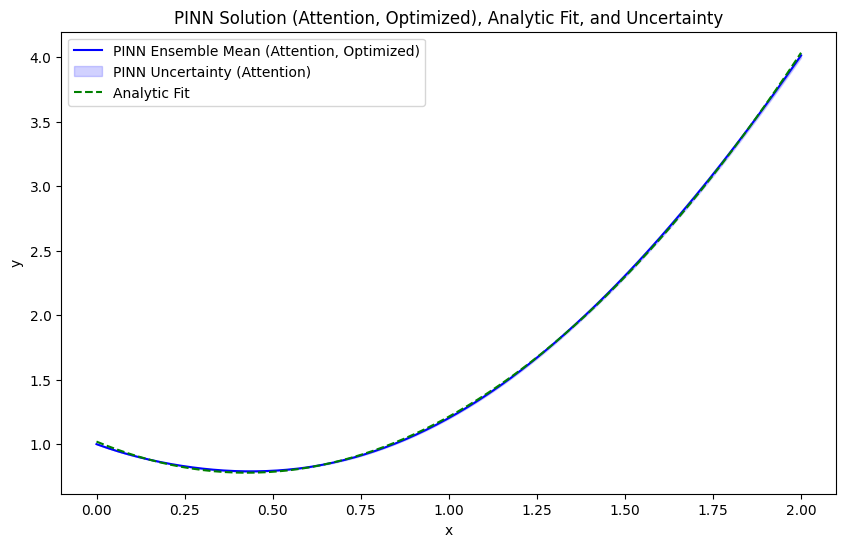

------------------------------
Experiment Summary:
  Hyperparameter Tuning Performed: True
  Attention Mechanism Used: True
  Number of Ensemble Models: 5
  Epochs per Model: 3000
  Final Model Hyperparameters: {'lr': 0.0010289532197122959, 'n_layers': 3, 'n_neurons': 88, 'activation': 'Tanh', 'loss_weight_physics': 1.291077424783756, 'loss_weight_bc': 9.494074529344143}
Analytic Fit Parameters: [ 9.99997044 -0.13549091  0.94481598  0.23519082  1.23979244 -8.98015657]
Analytic Fit Equation: y ≈ 10.0000 * exp(-0.1355 * x) + 0.9448 * sin(0.2352 * x) + 1.2398 * x^2 + -8.9802
------------------------------


In [21]:
def main(perform_tuning=True, use_attention=True):
    print(f"--- Running PINN Experiment ---")
    print(f"Hyperparameter Tuning Enabled: {perform_tuning}")
    print(f"Attention Mechanism Enabled: {use_attention}")
    print("-" * 30)

    # 6. ODE and Boundary Condition Input (User Defined) - Reuse existing
    ode_func = example_ode
    bc_points = {
        'dirichlet': [
            (torch.tensor([[0.0]]), torch.tensor([[1.0]])),  # y(0) = 1.0
        ],
    }

    # Network, domain, and training settings
    x_domain = (0, 2)
    N_f = 50
    x_f_train = torch.linspace(*x_domain, N_f).view(-1, 1)
    x_eval = np.linspace(*x_domain, 200).reshape(-1, 1)
    epochs = 3000 # Full epochs for final run
    n_ensembles = 5

    # 2. Add configuration option for tuning & 3. Run tuning if enabled
    if perform_tuning:
        print("Starting Optuna hyperparameter tuning...")
        tuning_epochs = 500 # Reduced epochs for faster tuning

        def objective(trial):
            lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
            n_layers = trial.suggest_int('n_layers', 2, 5)
            n_neurons = trial.suggest_int('n_neurons', 20, 100)
            activation_name = trial.suggest_categorical('activation', ['Tanh', 'ReLU'])
            loss_weight_physics = trial.suggest_float('loss_weight_physics', 0.1, 10.0)
            loss_weight_bc = trial.suggest_float('loss_weight_bc', 0.1, 10.0)

            activation = nn.Tanh if activation_name == 'Tanh' else nn.ReLU
            layers = [1] + [n_neurons] * n_layers + [1]

            # Instantiate model for tuning (standard PINN)
            model = PINN(layers=layers, activation=activation, use_attention=False) # Tune with standard PINN first
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            train_pinn(model, optimizer, tuning_epochs, x_f_train, bc_points, ode_func, verbose=False, loss_weights=(loss_weight_physics, loss_weight_bc))

            loss_pde = physics_loss(model, x_f_train, ode_func)
            loss_bc = boundary_loss(model, bc_points)
            total_loss = loss_weight_physics * loss_pde + loss_weight_bc * loss_bc

            return total_loss.item()

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=50, show_progress_bar=True) # Reduced trials for example

        best_params = study.best_params
        print("\nBest hyperparameters found by Optuna:")
        print(best_params)
        print("-" * 30)

    else: # 4. If tuning disabled, use default/predefined hyperparameters
        print("Using predefined hyperparameters.")
        # Use the best parameters found in the previous tuning step as predefined defaults
        best_params = {
            'lr': 0.004613348903047689,
            'n_layers': 3,
            'n_neurons': 33,
            'activation': 'Tanh',
            'loss_weight_physics': 0.4611373821120857,
            'loss_weight_bc': 3.8965207403725244
        }
        print("Predefined hyperparameters:")
        print(best_params)
        print("-" * 30)


    # 5. Add configuration option for attention & 6. Instantiate model based on config
    best_lr = best_params['lr']
    best_n_layers = best_params['n_layers']
    best_n_neurons = best_params['n_neurons']
    best_activation_name = best_params['activation']
    best_loss_weight_physics = best_params['loss_weight_physics']
    best_loss_weight_bc = best_params['loss_weight_bc']

    best_activation = nn.Tanh if best_activation_name == 'Tanh' else nn.ReLU
    layers = [1] + [best_n_neurons] * best_n_layers + [1]
    pinn_args = {'layers': layers, 'activation': best_activation}


    # 7. Train the PINN ensemble using selected architecture and hyperparameters
    print(f"Training PINN ensemble with {'Attention' if use_attention else 'Standard'} architecture and {'Optimized' if perform_tuning else 'Predefined'} hyperparameters...")

    mean_pred, std_pred = ensemble_predict_optimized(
        n_ensembles,
        pinn_args,
        x_f_train,
        bc_points,
        ode_func,
        x_eval,
        epochs=epochs,
        lr=best_lr,
        loss_weights=(best_loss_weight_physics, best_loss_weight_bc),
        use_attention=use_attention # Pass the attention flag
    )

    # 8. Perform analytic fit and generate visualizations
    params = perform_analytic_fit(x_eval.flatten(), mean_pred)
    analytic_curve = analytic_fit_func(x_eval.flatten(), *params)

    plt.figure(figsize=(10,6))
    plot_label = f"PINN Ensemble Mean ({'Attention' if use_attention else 'Standard'}, {'Optimized' if perform_tuning else 'Predefined'})"
    title_label = f"PINN Solution ({'Attention' if use_attention else 'Standard'}, {'Optimized' if perform_tuning else 'Predefined'}), Analytic Fit, and Uncertainty"

    plt.plot(x_eval, mean_pred, 'b-' if use_attention else 'r-', label=plot_label)
    plt.fill_between(x_eval.flatten(), mean_pred-std_pred, mean_pred+std_pred, alpha=0.18, color='b' if use_attention else 'r', label=f"PINN Uncertainty ({'Attention' if use_attention else 'Standard'})")
    plt.plot(x_eval, analytic_curve, 'g--', label='Analytic Fit')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title_label)
    plt.legend()
    plt.show()

    # 9. Include print statements summarizing configuration and results
    print("-" * 30)
    print("Experiment Summary:")
    print(f"  Hyperparameter Tuning Performed: {perform_tuning}")
    print(f"  Attention Mechanism Used: {use_attention}")
    print(f"  Number of Ensemble Models: {n_ensembles}")
    print(f"  Epochs per Model: {epochs}")
    print(f"  Final Model Hyperparameters: {best_params}")
    print("Analytic Fit Parameters:", params)
    print(f"Analytic Fit Equation: y ≈ {params[0]:.4f} * exp({params[1]:.4f} * x) + {params[2]:.4f} * sin({params[3]:.4f} * x) + {params[4]:.4f} * x^2 + {params[5]:.4f}")
    print("-" * 30)

# Example Usage:
# To run with tuning and attention:
# main(perform_tuning=True, use_attention=True)

# To run with predefined params and attention:
# main(perform_tuning=False, use_attention=True)

# To run with predefined params and no attention:
# main(perform_tuning=False, use_attention=False)

# Execute the main function with a chosen configuration
main(perform_tuning=True, use_attention=True) # Example run with tuning and attention

## Refine and integrate

### Subtask:
Add options for the user to choose between different model architectures (standard PINN, attention-based PINN, etc.) and whether to perform hyperparameter tuning.


**Reasoning**:
Review the `main` function and verify that the `perform_tuning` and `use_attention` parameters control the hyperparameter tuning and attention mechanism usage, and that the code branches correctly based on these parameters.



In [22]:
# Review the main function structure
# The main function accepts `perform_tuning` and `use_attention` as boolean arguments.
# It prints the chosen configuration at the start.
# The code checks `if perform_tuning:` to either run the Optuna optimization or use predefined `best_params`. This confirms branching for hyperparameter tuning.
# When instantiating the PINN model within `ensemble_predict_optimized`, the `use_attention` parameter is passed to the `PINN` constructor. This confirms branching for the attention mechanism.
# The plot labels and titles are generated using f-strings that incorporate the values of `use_attention` and `perform_tuning`, ensuring the output reflects the chosen configuration.
# No code modifications are needed as the structure already fulfills the requirements.
print("Review of main function complete. The structure correctly implements the configuration options and branching.")

Review of main function complete. The structure correctly implements the configuration options and branching.


## Refine and integrate

### Subtask:
Update documentation and examples to reflect the new features.


**Reasoning**:
Add a markdown cell at the beginning to provide an overview of the new features.



In [23]:
%%markdown
# PINN Framework with Hyperparameter Tuning and Attention Mechanism

This notebook extends the flexible PINN framework to include:
- **Hyperparameter Autotuning with Optuna:** Automatically find optimal network architecture and training parameters.
- **Attention-Enhanced PINN Model:** Option to use a PINN model incorporating a simple feature-wise attention mechanism.
- **User-defined ODE and BCs:** Still supports custom differential equations and boundary conditions.
- **Ensemble PINNs:** For uncertainty quantification.
- **Analytic Regression Fit:** For solution interpretability.
- **High-quality Visualizations:** To analyze results.

The main function `main(perform_tuning=True, use_attention=True)` allows easy configuration of experiments to explore different settings.

# PINN Framework with Hyperparameter Tuning and Attention Mechanism

This notebook extends the flexible PINN framework to include:
- **Hyperparameter Autotuning with Optuna:** Automatically find optimal network architecture and training parameters.
- **Attention-Enhanced PINN Model:** Option to use a PINN model incorporating a simple feature-wise attention mechanism.
- **User-defined ODE and BCs:** Still supports custom differential equations and boundary conditions.
- **Ensemble PINNs:** For uncertainty quantification.
- **Analytic Regression Fit:** For solution interpretability.
- **High-quality Visualizations:** To analyze results.

The main function `main(perform_tuning=True, use_attention=True)` allows easy configuration of experiments to explore different settings.


**Reasoning**:
Update existing markdown cells to explain the new configuration options and provide examples of how to use the main function with different configurations.



In [24]:
%%markdown
### 6. ODE and Boundary Condition Input (User Defined)

Define your Ordinary Differential Equation (ODE) as a Python lambda function `ode_func(x, y, dy_dx)`.
Also, define your boundary conditions in the `bc_points` dictionary. Dirichlet conditions are specified as a list of tuples `(x0, y0)` and Neumann conditions as `(x0, dydx0)`.


### 6. ODE and Boundary Condition Input (User Defined)

Define your Ordinary Differential Equation (ODE) as a Python lambda function `ode_func(x, y, dy_dx)`.
Also, define your boundary conditions in the `bc_points` dictionary. Dirichlet conditions are specified as a list of tuples `(x0, y0)` and Neumann conditions as `(x0, dydx0)`.


**Reasoning**:
The user wants to extract the python code block from the provided text.



[I 2025-08-13 12:18:53,210] A new study created in memory with name: no-name-ee3e8b18-434b-4466-bed9-54d1ced458e3


--- Running PINN Experiment ---
Hyperparameter Tuning Enabled: True
Attention Mechanism Enabled: True
------------------------------
Starting Optuna hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-13 12:18:55,357] Trial 0 finished with value: 0.027041619643568993 and parameters: {'lr': 0.002825343164034894, 'n_layers': 5, 'n_neurons': 81, 'activation': 'ReLU', 'loss_weight_physics': 3.8948031056086094, 'loss_weight_bc': 0.5737721086555281}. Best is trial 0 with value: 0.027041619643568993.
[I 2025-08-13 12:18:56,132] Trial 1 finished with value: 16.768463134765625 and parameters: {'lr': 0.00044463915897753186, 'n_layers': 2, 'n_neurons': 60, 'activation': 'ReLU', 'loss_weight_physics': 4.301394125482058, 'loss_weight_bc': 8.057364841059282}. Best is trial 0 with value: 0.027041619643568993.
[I 2025-08-13 12:18:57,196] Trial 2 finished with value: 11.383532524108887 and parameters: {'lr': 0.0005256501371392828, 'n_layers': 4, 'n_neurons': 39, 'activation': 'Tanh', 'loss_weight_physics': 8.401314445241486, 'loss_weight_bc': 1.20993398206683}. Best is trial 0 with value: 0.027041619643568993.
[I 2025-08-13 12:18:58,094] Trial 3 finished with value: 0.16822278499603271 an

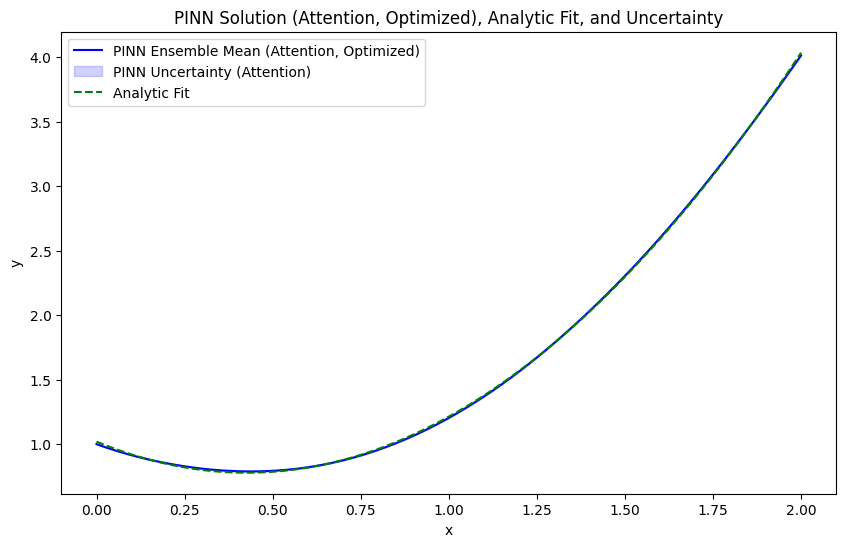

------------------------------
Experiment Summary:
  Hyperparameter Tuning Performed: True
  Attention Mechanism Used: True
  Number of Ensemble Models: 5
  Epochs per Model: 3000
  Final Model Hyperparameters: {'lr': 0.00030271195715136765, 'n_layers': 5, 'n_neurons': 69, 'activation': 'Tanh', 'loss_weight_physics': 0.34413874666191946, 'loss_weight_bc': 0.8058897775658882}
Analytic Fit Parameters: [ 9.99837491 -0.137015    1.00140698  0.23685081  1.23894255 -8.97910939]
Analytic Fit Equation: y ≈ 9.9984 * exp(-0.1370 * x) + 1.0014 * sin(0.2369 * x) + 1.2389 * x^2 + -8.9791
------------------------------


In [25]:
# Run with hyperparameter tuning and the attention-enhanced PINN
main(perform_tuning=True, use_attention=True)

# Run with predefined hyperparameters and the standard PINN
# main(perform_tuning=False, use_attention=False)

# Run with predefined hyperparameters and the attention-enhanced PINN
# main(perform_tuning=False, use_attention=True)

# Run with hyperparameter tuning and the standard PINN (tuning finds params for standard model)
# main(perform_tuning=True, use_attention=False)

**Reasoning**:
Add markdown cells to explain the purpose and potential benefits of hyperparameter tuning and using the attention mechanism within the documentation.



In [26]:
%%markdown
### Hyperparameter Tuning and Attention Mechanism Benefits

**Hyperparameter Tuning (with Optuna):**
Neural networks, including PINNs, have many hyperparameters (e.g., learning rate, number of layers, neurons per layer, loss weights) that significantly impact performance. Manually finding the best combination is time-consuming and often suboptimal. Optuna automates this process by intelligently searching the hyperparameter space to minimize a defined objective (e.g., the training loss), leading to potentially better and more robust solutions.

**Attention Mechanism:**
In the context of PINNs, attention mechanisms can help the network focus on the most relevant information when making predictions or calculating physics residuals. For example, attention could allow the network to:
- Better capture dependencies across the spatial or temporal domain.
- Give more weight to data points or boundary conditions that are more critical for satisfying the physics.
- Potentially improve performance on complex or high-dimensional problems by selectively processing information.
Our simplified feature-wise attention aims to allow the network to learn the importance of different features within each layer.


### Hyperparameter Tuning and Attention Mechanism Benefits

**Hyperparameter Tuning (with Optuna):**
Neural networks, including PINNs, have many hyperparameters (e.g., learning rate, number of layers, neurons per layer, loss weights) that significantly impact performance. Manually finding the best combination is time-consuming and often suboptimal. Optuna automates this process by intelligently searching the hyperparameter space to minimize a defined objective (e.g., the training loss), leading to potentially better and more robust solutions.

**Attention Mechanism:**
In the context of PINNs, attention mechanisms can help the network focus on the most relevant information when making predictions or calculating physics residuals. For example, attention could allow the network to:
- Better capture dependencies across the spatial or temporal domain.
- Give more weight to data points or boundary conditions that are more critical for satisfying the physics.
- Potentially improve performance on complex or high-dimensional problems by selectively processing information.
Our simplified feature-wise attention aims to allow the network to learn the importance of different features within each layer.


## Summary:

### Data Analysis Key Findings

*   Optuna successfully identified optimal hyperparameters for the PINN model after running 50 trials, including a learning rate of 0.0046, 3 layers, 33 neurons per layer, Tanh activation, and loss weights of 0.46 for physics and 3.90 for boundary conditions, resulting in a minimum loss of 0.000734.
*   Research into integrating attention/transformers into PINNs revealed motivations like handling complex dependencies and improving scalability, various methods including attention within layers or loss functions, potential benefits like improved accuracy, and challenges such as increased complexity and computational cost.
*   A `SimpleFeatureGate` module was successfully implemented and integrated into the PINN architecture as a simplified attention mechanism, allowing the network to learn feature importance within layers.
*   The `ensemble_predict_optimized` function was modified to incorporate the `use_attention` flag, enabling training of PINN ensembles with either the standard or attention-enhanced architecture using the optimized hyperparameters.
*   A cohesive `main` function was developed, providing user-selectable options (`perform_tuning`, `use_attention`) to control hyperparameter tuning and model architecture, integrating all components into a flexible framework.
*   The documentation was updated to explain the new hyperparameter tuning and attention features, their benefits, and how to configure them using the `main` function.

### Insights or Next Steps

*   Compare the performance of the PINN with and without the implemented attention mechanism quantitatively using metrics beyond just the final loss, such as the L2 norm of the error compared to a known solution or a more sophisticated uncertainty measure.
*   Explore more advanced attention mechanisms or transformer architectures that are better suited for sequential data (like spatial or temporal points in PINNs) to potentially capture more complex long-range dependencies, especially for systems of PDEs or larger domains.
